In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [43]:
from datetime import datetime

In [44]:
trantest_cus = pd.read_csv('trantest_cus.csv')

In [45]:
def columns_datetype_change(data, columns, datetype):
    if datetype == 'datetime64':
        for column in columns:
            data[column] = pd.to_datetime(data[column]).dt.strftime('%Y-%m-%d %H:%M:%S').astype('datetime64[ns]')

# 결측값 확인
def null_check(data):
    return (data.isnull().sum() / data.shape[0]) * 100

# 데이터 info
def data_info(data):
    display(data.head(5),data.info())

# 정수형, 실수형을 제외한 나머지 데이터타입의 유니크값
def colmuns_unique(data):
    for c in data.columns:
        if data[c].dtype not in ['int64', 'float64']:
            print(f'------------{c}------------')
            print(data[f'{c}'].unique())
            
def memory_small(data):
    for c in data.columns:
        if data[c].dtype == 'int64':
            data[c] = data[c].astype('int32')
        elif data[c].dtype == 'object' and data[c].nunique()<10:
            data[c] = data[c].astype('category')

In [46]:
columns_datetype_change(trantest_cus, ['first_join_date'], 'datetime64')
columns_datetype_change(trantest_cus, ['birthdate'], 'datetime64')

In [47]:
trantest_cus['first_join_date'] = pd.to_datetime(trantest_cus['first_join_date'])


In [48]:
trantest_cus['join_date'] = trantest_cus['first_join_date'].dt.strftime('%Y-%m')
trantest_cus['join_month'] = trantest_cus['first_join_date'].dt.strftime('%m')
trantest_cus['join_day'] = trantest_cus['first_join_date'].dt.strftime('%d')
trantest_cus['join_year'] = trantest_cus['first_join_date'].dt.strftime('%Y')

In [49]:
trantest_cus

,created_at,customer_id,promo_amount,shipment_fee,total_amount,quantity,shipment_period,booking_id,session_id,promo_code,...,join_date,join_month,join_day,join_year,created_at_3,created_at_5,가입 후 첫구매까지의 기간,age,age2,month
0,NaN,2870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nopromo,...,2019-07,07,21,2019,NaN,NaN,-1.0,27,20,NaN
1,NaN,8193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nopromo,...,2017-07,07,16,2017,NaN,NaN,-1.0,30,30,NaN
2,2020-08-23 12:53:12,7279,2853.0,15000.0,844751.0,3.0,2 days 16:20:52,1fb6f149-05ef-4a22-ac1a-cd5d98cd5510,9d0496a6-37f7-4d0a-8a04-5850a12d00a6,WEEKENDSERU,...,2020-08,08,23,2020,2020-08-23,2020.0,0.0,34,30,8.0
3,2020-08-31 13:34:59,7279,0.0,10000.0,391341.0,1.0,3 days 16:14:02,eed52035-1f80-422c-b0ac-a1c814e77bcf,82396d8d-7d8a-436d-8e14-75f24aa35faa,Nopromo,...,2020-08,08,23,2020,2020-08-31,2020.0,8.0,34,30,8.0
4,2020-09-08 13:38:30,7279,0.0,0.0,154220.0,1.0,5 days 21:47:50,af568d06-c819-4ab4-a3e8-06857786ba10,348cc997-480b-467e-a502-1eed0f611e9d,Nopromo,...,2020-08,08,23,2020,2020-09-08,2020.0,16.0,34,30,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901874,2021-12-07 17:31:02,40573,0.0,10000.0,1200173.0,4.0,4 days 20:38:30,6324e721-b59b-4c8b-9570-5ad30112be1e,f22b54dd-2766-4ac4-9e8e-9fb4572f6b03,Nopromo,...,2021-07,07,17,2021,2021-12-07,2021.0,143.0,35,30,12.0
901875,2022-01-23 19:01:48,40573,4532.0,10000.0,110483.0,1.0,2 days 06:39:23,65367fff-1522-4c80-a0f7-1306676bd947,4bb58af9-b2df-4c48-bcb7-d68749625cee,WEEKENDSERU,...,2021-07,07,17,2021,2022-01-23,2022.0,190.0,35,30,1.0
901876,2022-03-11 19:03:09,40573,0.0,25000.0,276290.0,1.0,2 days 07:13:24,7df40e00-5e2c-40c5-99f7-0e451ca82de4,a9c839a8-f945-4edb-b262-1d9196e2f827,Nopromo,...,2021-07,07,17,2021,2022-03-11,2022.0,237.0,35,30,3.0
901877,2022-04-27 20:00:55,40573,0.0,10000.0,258774.0,1.0,1 days 10:39:15,ae2b3e5b-0053-4671-ae18-f5a60b8a14dd,fcbf4865-4006-4bab-b9ca-3c0c0241c23d,Nopromo,...,2021-07,07,17,2021,2022-04-27,2022.0,284.0,35,30,4.0


In [50]:
trantest_cus.loc[trantest_cus['promo_code'].isnull(),'promo_code']='Nopromo'

In [51]:
value_counts = trantest_cus['promo_yesno'].value_counts()

In [52]:
value_counts

promo_yesno
x    526048
o    326536
Name: count, dtype: int64

In [53]:
trantest_cus['promo_yesno']

0         NaN
1         NaN
2           o
3           x
4           x
         ... 
901874      x
901875      o
901876      x
901877      x
901878      x
Name: promo_yesno, Length: 901879, dtype: object

In [54]:
trantest_cus['created_at_3'] = pd.to_datetime(trantest_cus['created_at']).dt.strftime('%Y-%m-%d').astype('datetime64[ns]')
trantest_cus['created_at_5'] = pd.to_datetime(trantest_cus['created_at']).dt.strftime('%Y')
trantest_cus['가입 후 첫구매까지의 기간'] = (pd.to_datetime(trantest_cus['created_at']) - trantest_cus['first_join_date']).dt.days.fillna(-1)

In [55]:
trantest_cus['birthdate'] = pd.to_datetime(trantest_cus['birthdate'])

In [56]:
trantest_cus['birthdate'] = pd.to_datetime(trantest_cus['birthdate'])

# 현재 날짜를 pandas Timestamp 객체로 변환
current_date = pd.Timestamp(datetime.now().date())

# 나이 계산
trantest_cus['age'] = (current_date - trantest_cus['birthdate']).dt.days // 365

# 'age' 컬럼을 사용해 'age2' 컬럼 생성
trantest_cus['age2'] = trantest_cus['age'].apply(lambda x : (x // 10) * 10)

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

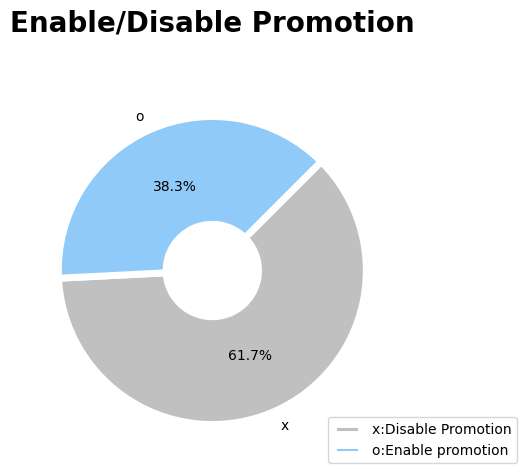

In [58]:
plt.figure(figsize=(5,5),facecolor='white')
colors = ['silver', '#90CAF9']  # Added the # to the color value
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
trantest_cus.promo_yesno.value_counts(normalize=True).plot.pie(textprops={'size':10}, colors=colors, wedgeprops=wedgeprops, autopct='%.1f%%', counterclock=False, startangle=45)
plt.title('Enable/Disable Promotion',fontsize=20, fontweight='bold', y=1.1)
plt.ylabel('')
plt.legend(['x:Disable Promotion','o:Enable promotion'], loc=[0.8,0])

Text(0, 0.5, '')

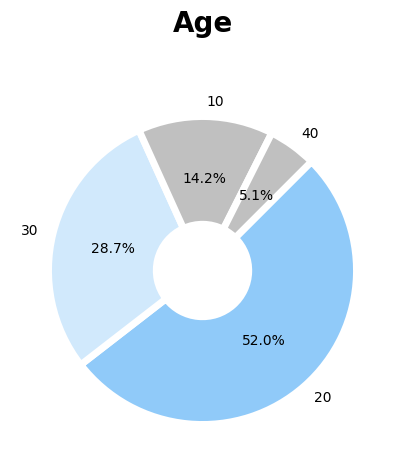

In [59]:
plt.figure(figsize=(5,5),facecolor='white')
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
colors = ['#90CAF9','#D1E9FC','silver','silver']
trantest_cus[(trantest_cus.age2<50) & (trantest_cus.age2>0)].age2.value_counts(normalize=True).plot.pie(textprops={'size':10},colors=colors,wedgeprops=wedgeprops,autopct='%.1f%%',counterclock=False,startangle=45)
plt.title('Age',fontsize=20,fontweight='bold',y=1.1)
plt.ylabel('')

수정필요

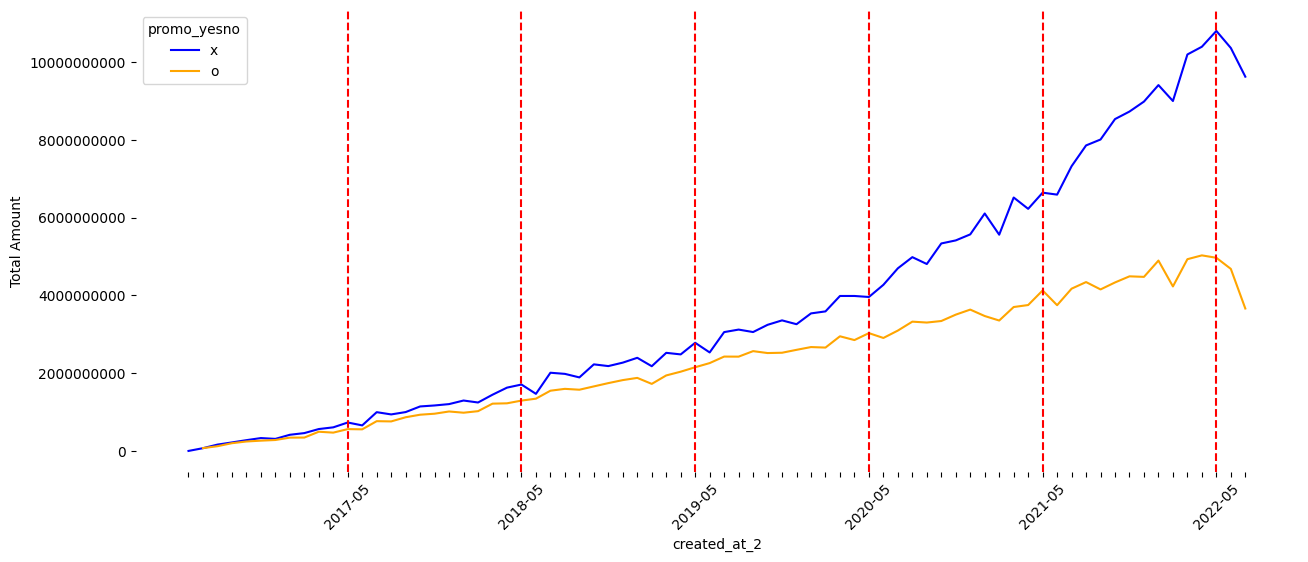

In [60]:
# Import necessary modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

# Create a figure and set its size
plt.figure(figsize=(15, 6))

# Set up a grid with one row
gs = gridspec.GridSpec(1, 1)

# Create the subplot for the line plot
ax1 = plt.subplot(gs[0])

# Filter the original data to only include rows where the payment was successful
# (Note: I'm assuming 'trantest_cus' is defined somewhere in your code)
filtered_data = trantest_cus[trantest_cus.payment_status == 'Success']

# Group this filtered data by 'created_at_2' and 'promo_yesno' and sum up the 'total_amount'
grouped_data = filtered_data.groupby(['created_at_2', 'promo_yesno'])['total_amount'].sum().reset_index()

# Create a line plot based on this grouped data with specific color palette
sns.lineplot(data=grouped_data, x='created_at_2', y='total_amount', hue='promo_yesno', ax=ax1, palette=['blue', 'orange'])

# Customize the x-axis labels to only show dates ending in '-05'
unique_dates = grouped_data['created_at_2'].unique()
filtered_dates = [date if date.endswith('-05') else '' for date in unique_dates]
plt.xticks(range(len(unique_dates)), filtered_dates, rotation=45)

# Turn off scientific notation for the y-axis
ax1.get_yaxis().get_major_formatter().set_scientific(False)

# Label the y-axis
ax1.set_ylabel('Total Amount')

# Add red dashed vertical lines for every date that ends in '-05'
for i, date in enumerate(unique_dates):
    if date.endswith('-05'):
        ax1.axvline(i, color='red', linestyle='--')

# Turn off the grids and spines for cleaner look
ax1.grid(False)
sns.despine(left=True, bottom=True, right=True)

# Show the plot
plt.show()


In [61]:
#판데믹이후로 프로모션이 적용되지않는 비용이 점점늘어가고있다.

In [ ]:
(15776684223.00-15051883083.00)/15776684223.00

0.04594128460423581

In [ ]:
((9629733539.00+3664976026.00)-(4970217464.00+10806466759.00))/(4970217464.00+10806466759.00)

-0.15731915673267133

In [ ]:
trantest_cus

,created_at,customer_id,promo_amount,shipment_fee,total_amount,quantity,shipment_period,booking_id,session_id,promo_code,...,join_date,join_month,join_day,join_year,created_at_3,created_at_5,가입 후 첫구매까지의 기간,age,age2,month
0,NaN,2870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nopromo,...,2019-07,07,21,2019,NaT,NaN,-1.00,27,20,NaN
1,NaN,8193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nopromo,...,2017-07,07,16,2017,NaT,NaN,-1.00,30,30,NaN
2,2020-08-23 12:53:12,7279,2853.00,15000.00,844751.00,3.00,2 days 16:20:52,1fb6f149-05ef-4a22-ac1a-cd5d98cd5510,9d0496a6-37f7-4d0a-8a04-5850a12d00a6,WEEKENDSERU,...,2020-08,08,23,2020,2020-08-23,2020,0.00,34,30,8.00
3,2020-08-31 13:34:59,7279,0.00,10000.00,391341.00,1.00,3 days 16:14:02,eed52035-1f80-422c-b0ac-a1c814e77bcf,82396d8d-7d8a-436d-8e14-75f24aa35faa,Nopromo,...,2020-08,08,23,2020,2020-08-31,2020,8.00,34,30,8.00
4,2020-09-08 13:38:30,7279,0.00,0.00,154220.00,1.00,5 days 21:47:50,af568d06-c819-4ab4-a3e8-06857786ba10,348cc997-480b-467e-a502-1eed0f611e9d,Nopromo,...,2020-08,08,23,2020,2020-09-08,2020,16.00,34,30,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901874,2021-12-07 17:31:02,40573,0.00,10000.00,1200173.00,4.00,4 days 20:38:30,6324e721-b59b-4c8b-9570-5ad30112be1e,f22b54dd-2766-4ac4-9e8e-9fb4572f6b03,Nopromo,...,2021-07,07,17,2021,2021-12-07,2021,143.00,35,30,12.00
901875,2022-01-23 19:01:48,40573,4532.00,10000.00,110483.00,1.00,2 days 06:39:23,65367fff-1522-4c80-a0f7-1306676bd947,4bb58af9-b2df-4c48-bcb7-d68749625cee,WEEKENDSERU,...,2021-07,07,17,2021,2022-01-23,2022,190.00,35,30,1.00
901876,2022-03-11 19:03:09,40573,0.00,25000.00,276290.00,1.00,2 days 07:13:24,7df40e00-5e2c-40c5-99f7-0e451ca82de4,a9c839a8-f945-4edb-b262-1d9196e2f827,Nopromo,...,2021-07,07,17,2021,2022-03-11,2022,237.00,35,30,3.00
901877,2022-04-27 20:00:55,40573,0.00,10000.00,258774.00,1.00,1 days 10:39:15,ae2b3e5b-0053-4671-ae18-f5a60b8a14dd,fcbf4865-4006-4bab-b9ca-3c0c0241c23d,Nopromo,...,2021-07,07,17,2021,2022-04-27,2022,284.00,35,30,4.00


In [ ]:
# Group by age group and promotion used and calculate the counts
age_promo_group = trantest_cus.groupby(['age2', 'promo_yesno']).size().reset_index(name='counts')

# Calculate the total number of entries for each age group
age_total = trantest_cus.groupby('age2').size().reset_index(name='total_counts')

# Merge both DataFrames on 'age2' to have counts and total_counts side by side
merged_df = pd.merge(age_promo_group, age_total, on='age2')

# Calculate the usage rate
merged_df['usage_rate'] = (merged_df['counts'] / merged_df['total_counts']) * 100


In [ ]:
merged_df

,age2,promo_yesno,counts,total_counts,usage_rate
0,0,o,196,559,35.06
1,0,x,340,559,60.82
2,10,o,46719,127362,36.68
3,10,x,73904,127362,58.03
4,20,o,169287,466450,36.29
5,20,x,271547,466450,58.22
6,30,o,92519,257493,35.93
7,30,x,150903,257493,58.60
8,40,o,16153,45404,35.58
9,40,x,26650,45404,58.70


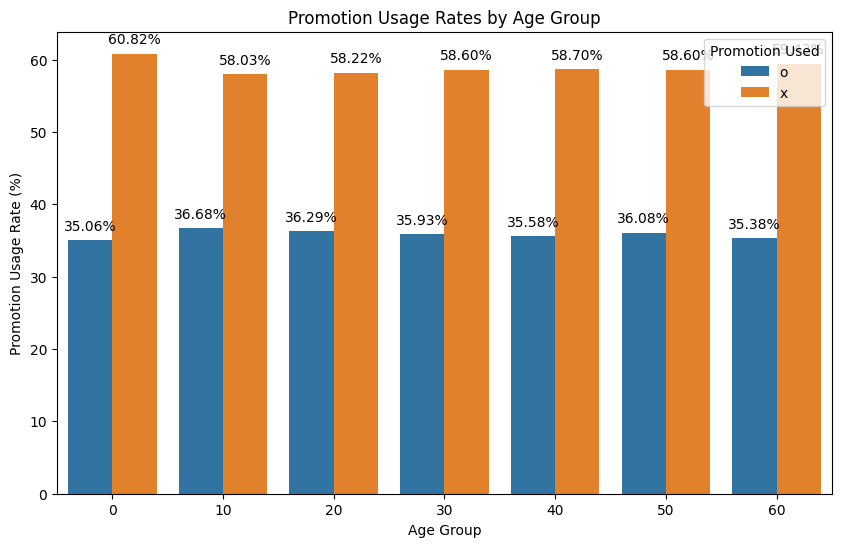

In [ ]:
# Plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_df, x='age2', y='usage_rate', hue='promo_yesno')
plt.xlabel('Age Group')
plt.ylabel('Promotion Usage Rate (%)')
plt.title('Promotion Usage Rates by Age Group')
plt.legend(title='Promotion Used', loc='upper right')

# Annotating the bars
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.2f}%", 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', 
                       va='center', 
                       xytext=(0, 10), 
                       textcoords='offset points')

plt.show()


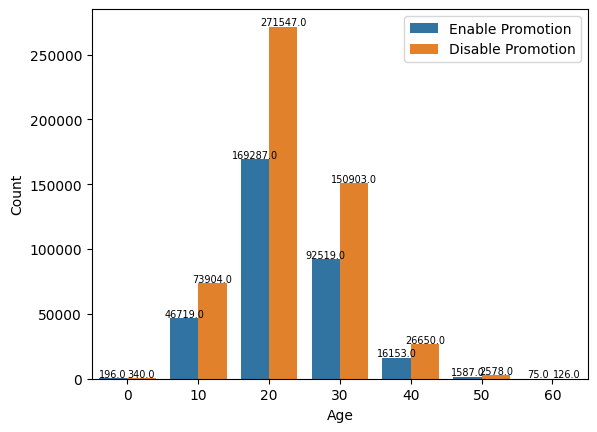

In [ ]:
NA = sns.countplot(data=trantest_cus, x='age2',hue='promo_yesno')
plt.legend(['Enable Promotion','Disable Promotion'])
plt.xlabel('Age')
plt.ylabel('Count')
for patch in NA.patches:
    plt.text(x=patch.get_x() + patch.get_width()/2 ,y=patch.get_height() + len(trantest_cus)*0.001,s=patch.get_height(), ha='center',size=7)

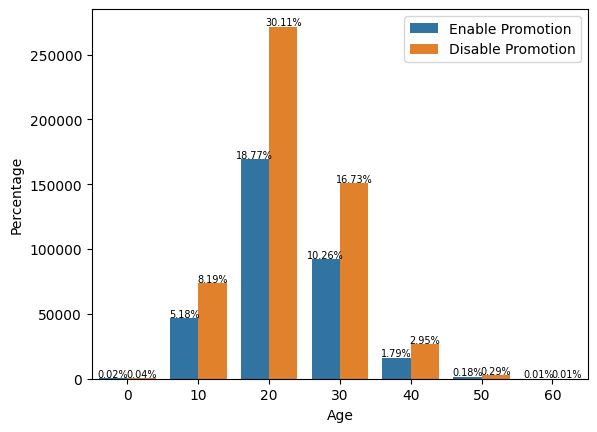

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Replace this line with the code to load your actual DataFrame
# trantest_cus = pd.read_csv("your_data.csv")

# Create the countplot
ax = sns.countplot(data=trantest_cus, x='age2', hue='promo_yesno')
plt.legend(['Enable Promotion', 'Disable Promotion'])
plt.xlabel('Age')
plt.ylabel('Percentage')

# Calculate the total number of observations
total = len(trantest_cus)

# Initialize list to store percentages
percentages = []

# Loop through the patches to get the count and calculate percentages
for patch in ax.patches:
    count = patch.get_height()
    percentages.append((count / total) * 100)

# Loop through the patches again to annotate the bars
for i, patch in enumerate(ax.patches):
    # Use the previously calculated percentages for annotation
    percentage = percentages[i]
    
    # Annotate the bar
    ax.text(x=patch.get_x() + patch.get_width() / 2,
            y=patch.get_height() + total * 0.001,
            s=f'{percentage:.2f}%',
            ha='center',
            size=7)

plt.show()
